# Topic Modeling

This notebook establishes a process for automating a topic modeling process

In [4]:
# Required Libraries

#Base and Cleaning 
import json
import requests
import pandas as pd
import numpy as np
import emoji
import regex
import re
import string
from collections import Counter

#Visualizations
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import pyLDAvis.gensim_models
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

#Natural Language Processing (NLP)
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from wordcloud import STOPWORDS
stopwords = set(STOPWORDS)

/Users/jeintron/.pyenv/versions/3.9.1/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [25]:
import gensim.parsing.preprocessing as pp


def give_emoji_free_text(text):
    """
    Removes emoji's from tweets
    Accepts:
        Text (tweets)
    Returns:
        Text (emoji free tweets)
    """
    emoji_list = [c for c in text if c in emoji.UNICODE_EMOJI]
    clean_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return clean_text


def punctuation_free_text(text):
    '''
    Cleans punctuation from text
    '''

    text = " ".join(pp.preprocess_string(text,[pp.strip_numeric,pp.strip_punctuation,pp.strip_short]))
    return text

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    return text

def mention_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'@\S+', '', text)
    return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: give_emoji_free_text(x)

just_text = x[['tweet_id','tweet_text']]

# Apply `call_emoji_free` which calls the function to remove all emoji's
just_text['processed'] = just_text['tweet_text'].apply(call_emoji_free).apply(url_free_text).apply(mention_free_text).apply(punctuation_free_text)



just_text

,tweet_id,tweet_text,processed
42864,1114247944058867713,This is my first tweet. Don't use twitter much...,This first tweet Don use twitter much Add and ...
42863,1121808620428120066,Second tweet all time - you should buy my book...,Second tweet all time you should buy book
42862,1132065512429506561,really enjoyed this convo with @GlennLoury - h...,really enjoyed this convo with hate hoaxes rac...
42861,1132066052488278016,Kudos to @MrAndyNgo for this share of my work ...,Kudos for this share work which see went viral...
42860,1132066953315672064,"The atheists LOVE ME, SON!!! Good discussion o...",The atheists LOVE SON Good discussion hate hoa...
...,...,...,...
4,1494052729576120321,"Snipe hunt, like I always do on the seventy-le...",Snipe hunt like always the seventy leventh Never
3,1494061609286881281,Only one caveat: you can sub any heterodox gro...,Only one caveat you can sub any heterodox grou...
2,1494077501336866818,Never do an enemy a small injury. https://t.co...,Never enemy small injury
1,1494079237912940550,"""If you fight me, I will turn your nation into...",you fight will turn your nation into memory wi...


In [83]:
# Load spacy
# Make sure to restart the runtime after running installations and libraries tab
nlp = spacy.load('en_core_web_sm')
#tokenizer = Tokenizer(nlp.vocab)




In [104]:
# Custom stopwords
custom_stopwords = ['&mldr;','...','etc','don','hi','\n','\n\n', '&amp;', ' ', '.', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@']

# Customize stop words by adding to the default list
STOP_WORDS = nlp.Defaults.stop_words.union(custom_stopwords)

# ALL_STOP_WORDS = spacy + gensim + wordcloud
ALL_STOP_WORDS = STOP_WORDS.union(SW).union(stopwords)
tokens = []

for doc in nlp.pipe(just_text['processed'], batch_size=500, disable=["parser", "ner"]):
    doc_tokens = []    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.lemma_.lower())   
    tokens.append(doc_tokens)

# Makes tokens column
just_text['tokens'] = tokens

In [103]:
# Running some tests here to try to optimize things.

# sentences = [
#     "Women and men like to play games that are fun",
#     "Everybody seems to talk about racism, but does anyone really care?"
# ]

# sentences = sentences * 25000
# import os
# os.environ["TOKENIZERS_PARALLELISM"]="false"

# print(nlp.pipe_names)
# result = []
# for doc in nlp.pipe(sentences, batch_size=500, n_process=12,  disable=["parser", "ner"]):
#     for token in doc:
#         result.append(token.lemma_)


['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


In [52]:
just_text

,tweet_id,tweet_text,processed,tokens
42864,1114247944058867713,This is my first tweet. Don't use twitter much...,This first tweet Don use twitter much Add and ...,"[tweet, use, twitter, add, ytube, wilfred, rei..."
42863,1121808620428120066,Second tweet all time - you should buy my book...,Second tweet all time you should buy book,"[second, tweet, time, buy, book]"
42862,1132065512429506561,really enjoyed this convo with @GlennLoury - h...,really enjoyed this convo with hate hoaxes rac...,"[enjoyed, convo, hate, hoaxes, race, relations..."
42861,1132066052488278016,Kudos to @MrAndyNgo for this share of my work ...,Kudos for this share work which see went viral...,"[kudos, share, work, went, viral, likes, loves..."
42860,1132066953315672064,"The atheists LOVE ME, SON!!! Good discussion o...",The atheists LOVE SON Good discussion hate hoa...,"[atheists, love, son, good, discussion, hate, ..."
...,...,...,...,...
4,1494052729576120321,"Snipe hunt, like I always do on the seventy-le...",Snipe hunt like always the seventy leventh Never,"[snipe, hunt, seventy, leventh]"
3,1494061609286881281,Only one caveat: you can sub any heterodox gro...,Only one caveat you can sub any heterodox grou...,"[caveat, sub, heterodox, group, literally, dis..."
2,1494077501336866818,Never do an enemy a small injury. https://t.co...,Never enemy small injury,"[enemy, small, injury]"
1,1494079237912940550,"""If you fight me, I will turn your nation into...",you fight will turn your nation into memory wi...,"[fight, turn, nation, memory, year, caesar, re..."


In [105]:
# Create a id2word dictionary
id2word = Dictionary(just_text['tokens'])
print(len(id2word))

26307


In [106]:
# Filtering Extremes
id2word.filter_extremes(no_below=2, no_above=.9)
print(len(id2word))

15046


In [107]:
# Creating a corpus object 
corpus = [id2word.doc2bow(d) for d in just_text['tokens']]

In [108]:
# Instantiating a Base LDA model 
base_model = LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)

In [109]:
# Filtering for words 
words = [re.findall(r'"([^"]*)"',t[1]) for t in base_model.print_topics()]

In [110]:
# Create Topics
topics = [' '.join(t[0:10]) for t in words]

In [111]:
# Getting the topics
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
people point think white death sure black covid kill risk

------ Topic 1 ------
white people black group point racism man good think class

------ Topic 2 ------
crime white rate black people year right race thing say

------ Topic 3 ------
point study group good right white gap score time test

------ Topic 4 ------
people right thing know guy state woman argument point say



In [112]:
# Compute Perplexity
# a measure of how good the model is. lower the better
base_perplexity = base_model.log_perplexity(corpus)
print('\nPerplexity: ', base_perplexity) 

# Compute Coherence Score
coherence_model = CoherenceModel(model=base_model, texts=just_text['tokens'], 
                                   dictionary=id2word, coherence='c_v')
coherence_lda_model_base = coherence_model.get_coherence()
print('\nCoherence Score: ', coherence_lda_model_base)


Perplexity:  -8.063702865519353

Coherence Score:  0.26406937594176605


In [113]:
#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(base_model, corpus, id2word)

/Users/jeintron/.pyenv/versions/3.9.1/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jeintron/.pyenv/versions/3.9.1/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jeintron/.pyenv/versions/3.9.1/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jeintron/.pyenv/versions/3.9.1/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jeintron/.pyenv/versions/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.027581  0.003952       1        1  22.335855
0     -0.042839 -0.024927       2        1  21.587878
2     -0.012851 -0.045114       3        1  19.394666
3      0.062789  0.005493       4        1  18.639438
4     -0.034681  0.060596       5        1  18.042162, topic_info=           Term         Freq        Total Category  logprob  loglift
313       crime  2503.000000  2503.000000  Default  30.0000  30.0000
206        rate  2085.000000  2085.000000  Default  29.0000  29.0000
103       white  6296.000000  6296.000000  Default  28.0000  28.0000
611       study  1285.000000  1285.000000  Default  27.0000  27.0000
2215       risk   815.000000   815.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
40          man   346.377796  2015.484457   Topic5  -5.7597  -0.0486
103       white   426.175182  6296.959772   Topic5  -5.5524  -0.9805
285   literally   315.216021  2041.670244   Topic5  -5.8540  -0.1558
106       class   305.281416  1649.821701   Topic5  -5.8860   0.0253
342        real   304.467010  2159.175361   Topic5  -5.8887  -0.2465

[500 rows x 6 columns], token_table=       Topic      Freq  Term
term                        
888        1  0.738818  ADOS
888        2  0.071498  ADOS
888        3  0.059582  ADOS
888        4  0.083415  ADOS
888        5  0.047666  ADOS
...      ...       ...   ...
6430       2  0.136800     …
6430       3  0.169371     …
6430       4  0.194342     …
6430       5  0.096628     …
12410      4  0.848305     💯

[1444 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3, 4, 5])

In [115]:
just_text['lemmas_to_text'] = just_text['tokens'].apply(lambda x:" ".join(x))
vectorizer = CountVectorizer()
data_vectorized = vectorizer.fit_transform(just_text['lemmas_to_text'])
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             iid=True, n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

TypeError: __init__() got an unexpected keyword argument 'iid'

In [116]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -1137185.5648689382
Model Perplexity:  3037.465951904839


In [117]:
#Defining a function to loop over number of topics to be used to find an 
#optimal number of tipics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the 
    LDA model with respective number of topics
    """
    coherence_values_topic = []
    model_list_topic = []
    for num_topics in range(start, limit, step):
        model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list_topic.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values_topic.append(coherencemodel.get_coherence())

    return model_list_topic, coherence_values_topic    
# Can take a long time to run.
model_list_topic, coherence_values_topic = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=just_text['tokens'],
                                                        start=2, limit=100, step=5)

In [121]:
model_list_topic[1].num_topics

7

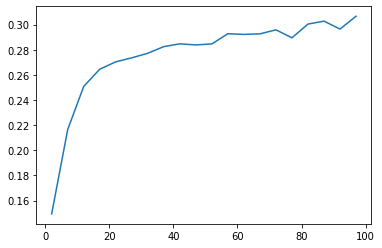

In [122]:
%matplotlib inline
import matplotlib.pyplot as plot
num_topics = [x.num_topics for x in model_list_topic]
plt.plot(num_topics,coherence_values_topic)

[0.1494253553397213] 0.1494253553397213
[0.1494253553397213, 0.21645263577878762] 0.18293899555925447
[0.21645263577878762, 0.2507985374528752] 0.23362558661583144
[0.2507985374528752, 0.2644741003529305] 0.25763631890290284
[0.2644741003529305, 0.27034995053047467] 0.2674120254417026
[0.27034995053047467, 0.27353901889517007] 0.2719444847128224
[0.27353901889517007, 0.27715898954321405] 0.27534900421919206
[0.27715898954321405, 0.2824627131623364] 0.2798108513527752
[0.2824627131623364, 0.2846627852458637] 0.2835627492041001
[0.2846627852458637, 0.2837859150488159] 0.2842243501473398
[0.2837859150488159, 0.28460632059381846] 0.28419611782131715
[0.28460632059381846, 0.2926936342394133] 0.2886499774166159
[0.2926936342394133, 0.2921589605482567] 0.29242629739383497
[0.2921589605482567, 0.29258127467928313] 0.2923701176137699
[0.29258127467928313, 0.29579517080692885] 0.29418822274310596
[0.29579517080692885, 0.2894618545766832] 0.292628512691806
[0.2894618545766832, 0.30037586969910046

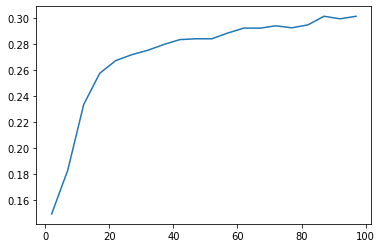

In [131]:
# Roll my own
from statistics import mean
smoothed=[]
win_size = 1
for x in range(len(coherence_values_topic)):
    l,r = max(0,x-win_size), min(len(coherence_values_topic),x+win_size)
    sample = ç[l:r]
    print(sample,mean(sample))
    smoothed.append(mean(sample))

plt.plot(num_topics,smoothed)



    



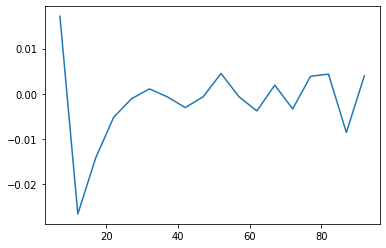

In [136]:
x = []
secondDerivative = []
for i in range(1,len(smoothed)-1):
    x.append(num_topics[i])
    secondDerivative.append(smoothed[i+1] + smoothed[i-1] - 2 * smoothed[i])


plt.plot(x,secondDerivative)

In [138]:
from kneed import KneeLocator
kneedle = KneeLocator(num_topics,coherence_values_topic,curve="concave",direction="increasing")
print(kneedle.knee)

17


In [139]:
num_topics

[2, 7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82, 87, 92, 97]

In [140]:
best_model = model_list_topic[3]
words = [re.findall(r'"([^"]*)"',t[1]) for t in best_model.print_topics()]
topics = [' '.join(t[0:10]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
white crime black race post think sure literally state book

------ Topic 1 ------
black people white good think year mean point say problem

------ Topic 2 ------
white people group race year point crime think black real

------ Topic 3 ------
think people point white guy good mean black link year

------ Topic 4 ------
people white point test rate black real right woman datum

------ Topic 5 ------
black white people work crime real group good look point

------ Topic 6 ------
point group people white race black right crime thing year

------ Topic 7 ------
white black point people crime rate group say think true

------ Topic 8 ------
people white black say actually crime thing think case good

------ Topic 9 ------
people point think white black mean rate literally right guy

------ Topic 10 ------
point people year state woman real right mean white level

------ Topic 11 ------
people black white real death rate say man literally point

------ Topic 12 ------

In [141]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(best_model, corpus, id2word)

/Users/jeintron/.pyenv/versions/3.9.1/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jeintron/.pyenv/versions/3.9.1/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jeintron/.pyenv/versions/3.9.1/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jeintron/.pyenv/versions/3.9.1/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/jeintron/.pyenv/versions/

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.011835 -0.008642       1        1  8.033856
6      0.011778 -0.013857       2        1  7.474485
16    -0.004404 -0.001932       3        1  7.337288
5      0.012202 -0.010852       4        1  7.013327
11     0.004021 -0.007448       5        1  6.910214
12     0.001414 -0.005712       6        1  6.559842
2      0.016624 -0.011137       7        1  6.045588
9     -0.005100 -0.001543       8        1  6.015718
14    -0.005799 -0.002001       9        1  5.819822
4      0.007609 -0.014090      10        1  5.759187
3     -0.001759  0.013302      11        1  5.588559
8      0.010961  0.001023      12        1  5.570992
1      0.002517 -0.014235      13        1  4.698961
0      0.011189 -0.011597      14        1  4.470234
10    -0.000624  0.001788      15        1  4.470173
15     0.014014  0.083558      16        1  4.278913
13    -0.086478  0.003375      17        1  3.952841, topic_info=       Term         Freq        Total Category  logprob  loglift
103   white  6560.000000  6560.000000  Default  30.0000  30.0000
73    think  2953.000000  2953.000000  Default  29.0000  29.0000
106   class  1634.000000  1634.000000  Default  28.0000  28.0000
194  people  5932.000000  5932.000000  Default  27.0000  27.0000
313   crime  2746.000000  2746.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
448   datum    58.702747  1315.489285  Topic17  -6.0165   0.1213
35    right    70.872929  3157.001056  Topic17  -5.8281  -0.5658
59     look    63.231443  1923.666536  Topic17  -5.9422  -0.1845
34     mean    61.865920  2147.580270  Topic17  -5.9640  -0.3164
313   crime    57.569657  2746.659266  Topic17  -6.0360  -0.6344

[1368 rows x 6 columns], token_table=       Topic      Freq Term
term                       
2592       1  0.069007    "
2592       2  0.051755    "
2592       3  0.017252    "
2592       4  0.017252    "
2592       5  0.051755    "
...      ...       ...  ...
6430      14  0.072831    …
6430      15  0.029913    …
6430      16  0.049421    …
6430      17  0.026011    …
12410     13  0.920184    💯

[6201 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 7, 17, 6, 12, 13, 3, 10, 15, 5, 4, 9, 2, 1, 11, 16, 14])

In [143]:
corpus[0:10]


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)],
 [(2, 1), (6, 1), (7, 1), (8, 1), (9, 1)],
 [(10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1)],
 [(20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1)],
 [(13, 1),
  (14, 1),
  (24, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1)],
 [(37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1)],
 [(14, 1),
  (35, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1)],
 [(10, 1),
  (17, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1)],
 [(10, 1),
  (14, 1),
  (15, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 1)],
 [(32, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1)]]

In [146]:
for i in best_model.get_document_topics(corpus[0:10]):
    print(i)

[(12, 0.865323)]
[(0, 0.8431143)]
[(12, 0.914353)]
[(5, 0.90577257)]
[(1, 0.9215139)]
[(0, 0.88224036)]
[(8, 0.5312353), (14, 0.40565988)]
[(14, 0.90586287)]
[(14, 0.90585995)]
[(8, 0.8823371)]


In [147]:
best_model.get_document_topics(corpus[0:10])

In [155]:
assignments = pd.DataFrame([ dict([(f"topic_{x[0]}",x[1]) for x in y]) for y in best_model.get_document_topics(corpus)]).fillna(0)

In [251]:
def weighted_jaccard(s,t):
    n = sum([x for x in map(min,zip(s,t))])
    d = sum([x for x in map(max,zip(s,t))])
    return(0 if d==0 else n/d)



In [242]:
x

,tweet_created_at,tweet_id,tweet_text,tweet_author_id,tweet_conversation_id,tweet_entities,tweet_public_metrics,tweet_referenced_tweets_id,tweet_referenced_tweets_type,tweet_in_reply_to_user_id
0,2019-04-05 19:26:26+00:00,1114247944058867713,This is my first tweet. Don't use twitter much...,1011008340367953920,1114247944058867713,"{'hashtags': [{'start': 90, 'end': 97, 'tag': ...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",None,None,NaN
1,2019-04-26 16:09:51+00:00,1121808620428120066,Second tweet all time - you should buy my book...,1011008340367953920,1121808620428120066,"{'urls': [{'start': 48, 'end': 71, 'url': 'htt...","{'retweet_count': 2, 'reply_count': 0, 'like_c...",None,None,NaN
2,2019-05-24 23:27:05+00:00,1132065512429506561,really enjoyed this convo with @GlennLoury - h...,1011008340367953920,1132065512429506561,"{'mentions': [{'start': 31, 'end': 42, 'userna...","{'retweet_count': 1, 'reply_count': 1, 'like_c...",None,None,NaN
3,2019-05-24 23:29:14+00:00,1132066052488278016,Kudos to @MrAndyNgo for this share of my work ...,1011008340367953920,1132066052488278016,"{'mentions': [{'start': 9, 'end': 19, 'usernam...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",1099797854149795840,quoted,NaN
4,2019-05-24 23:32:49+00:00,1132066953315672064,"The atheists LOVE ME, SON!!! Good discussion o...",1011008340367953920,1132066953315672064,"{'mentions': [{'start': 101, 'end': 115, 'user...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",None,None,NaN
...,...,...,...,...,...,...,...,...,...,...
42860,2022-02-16 20:55:03+00:00,1494052729576120321,"Snipe hunt, like I always do on the seventy-le...",1011008340367953920,1494052729576120321,"{'urls': [{'start': 62, 'end': 85, 'url': 'htt...","{'retweet_count': 1, 'reply_count': 2, 'like_c...",1494015142463479811,quoted,NaN
42861,2022-02-16 21:30:20+00:00,1494061609286881281,Only one caveat: you can sub any heterodox gro...,1011008340367953920,1494061609286881281,"{'urls': [{'start': 190, 'end': 213, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",1494056710515867650,quoted,NaN
42862,2022-02-16 22:33:29+00:00,1494077501336866818,Never do an enemy a small injury. https://t.co...,1011008340367953920,1494077501336866818,"{'urls': [{'start': 34, 'end': 57, 'url': 'htt...","{'retweet_count': 2, 'reply_count': 1, 'like_c...",1494019836502056961,quoted,NaN
42863,2022-02-16 22:40:23+00:00,1494079237912940550,"""If you fight me, I will turn your nation into...",1011008340367953920,1494079237912940550,None,"{'retweet_count': 3, 'reply_count': 9, 'like_c...",None,None,NaN


In [273]:
topic_cols = assignments.columns.to_list()
full_frame = pd.merge(x,assignments,left_index=True,right_index=True)
full_frame["date_floor"] = full_frame['tweet_created_at'].dt.floor("D")
days = pd.date_range(full_frame["date_floor"].min(),full_frame["date_floor"].max())
days = pd.DataFrame({"day":days.to_list()})
expanded_frame = pd.merge(days,full_frame,how="left",left_on="day",right_on="date_floor")
tmp = expanded_frame[['day']+topic_cols].fillna(0)
tmp = tmp.groupby('day').mean()
print(tmp.info())
win_size = 3
tmp = tmp.rolling(win_size).mean().iloc[win_size-1:,:]
tmp["id"] = tmp.index
tmp = pd.wide_to_long(tmp,stubnames="topic_",i="id",j="topicid")
tmp["next_weight"] = tmp.groupby(level="topicid")['topic_'].shift(-1)
tmp = tmp.dropna().reset_index()
j = tmp.groupby("id").apply(lambda x: weighted_jaccard(x.topic_,x.next_weight))
j.name = "jaccard"
pd.merge(expanded_frame,j,left_index = True, right_index = True, how="left")




<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1049 entries, 2019-04-05 00:00:00+00:00 to 2022-02-16 00:00:00+00:00
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   topic_12  1049 non-null   float64
 1   topic_0   1049 non-null   float64
 2   topic_5   1049 non-null   float64
 3   topic_1   1049 non-null   float64
 4   topic_8   1049 non-null   float64
 5   topic_14  1049 non-null   float64
 6   topic_2   1049 non-null   float64
 7   topic_3   1049 non-null   float64
 8   topic_4   1049 non-null   float64
 9   topic_6   1049 non-null   float64
 10  topic_7   1049 non-null   float64
 11  topic_9   1049 non-null   float64
 12  topic_10  1049 non-null   float64
 13  topic_11  1049 non-null   float64
 14  topic_13  1049 non-null   float64
 15  topic_15  1049 non-null   float64
 16  topic_16  1049 non-null   float64
dtypes: float64(17)
memory usage: 147.5 KB
None


,day,tweet_created_at,tweet_id,tweet_text,tweet_author_id,tweet_conversation_id,tweet_entities,tweet_public_metrics,tweet_referenced_tweets_id,tweet_referenced_tweets_type,...,topic_6,topic_7,topic_9,topic_10,topic_11,topic_13,topic_15,topic_16,date_floor,jaccard
0,2019-04-05 00:00:00+00:00,2019-04-05 19:26:26+00:00,1.114248e+18,This is my first tweet. Don't use twitter much...,1.011008e+18,1.114248e+18,"{'hashtags': [{'start': 90, 'end': 97, 'tag': ...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",None,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2019-04-05 00:00:00+00:00,NaN
1,2019-04-06 00:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
2,2019-04-07 00:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3,2019-04-08 00:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
4,2019-04-09 00:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42933,2022-02-16 00:00:00+00:00,2022-02-16 20:55:03+00:00,1.494053e+18,"Snipe hunt, like I always do on the seventy-le...",1.011008e+18,1.494053e+18,"{'urls': [{'start': 62, 'end': 85, 'url': 'htt...","{'retweet_count': 1, 'reply_count': 2, 'like_c...",1494015142463479811,quoted,...,0.019670,0.019670,0.019670,0.019670,0.019670,0.685279,0.019670,0.019670,2022-02-16 00:00:00+00:00,NaN
42934,2022-02-16 00:00:00+00:00,2022-02-16 21:30:20+00:00,1.494062e+18,Only one caveat: you can sub any heterodox gro...,1.011008e+18,1.494062e+18,"{'urls': [{'start': 190, 'end': 213, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",1494056710515867650,quoted,...,0.000000,0.000000,0.599945,0.000000,0.000000,0.000000,0.000000,0.348075,2022-02-16 00:00:00+00:00,NaN
42935,2022-02-16 00:00:00+00:00,2022-02-16 22:33:29+00:00,1.494078e+18,Never do an enemy a small injury. https://t.co...,1.011008e+18,1.494078e+18,"{'urls': [{'start': 34, 'end': 57, 'url': 'htt...","{'retweet_count': 2, 'reply_count': 1, 'like_c...",1494019836502056961,quoted,...,0.014736,0.014736,0.014736,0.014736,0.014736,0.014736,0.014736,0.764218,2022-02-16 00:00:00+00:00,NaN
42936,2022-02-16 00:00:00+00:00,2022-02-16 22:40:23+00:00,1.494079e+18,"""If you fight me, I will turn your nation into...",1.011008e+18,1.494079e+18,None,"{'retweet_count': 3, 'reply_count': 9, 'like_c...",None,None,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2022-02-16 00:00:00+00:00,NaN


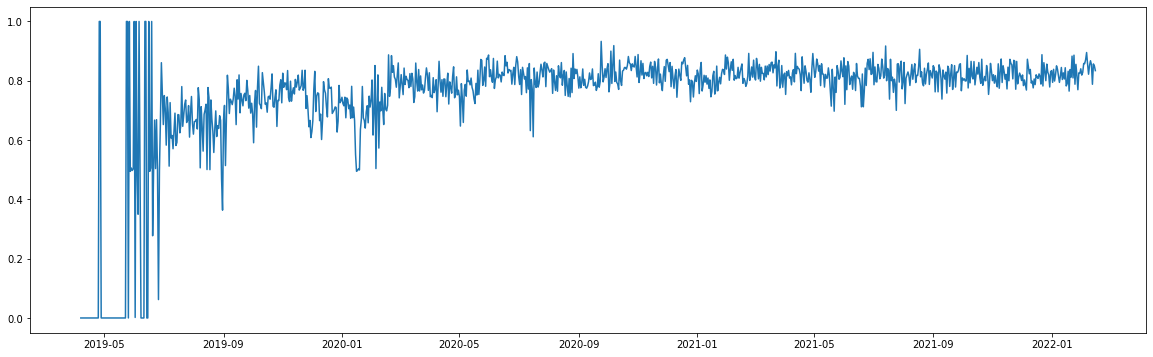

In [274]:
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(j)

In [249]:
tmp

,,topic_
id,topicid,
6,12,0.123618
7,12,0.000000
8,12,0.000000
9,12,0.000000
10,12,0.000000
...,...,...
42933,16,0.069505
42934,16,0.060938
42935,16,0.170112


In [200]:
import pandas as pd

x = df.iloc[0,:]
y = df.iloc[1,:]
weighted_jaccard(x,y)

0.818249170440242

In [192]:



df["id"] = df.index
df = pd.wide_to_long(df,stubnames="topic_",i="id",j="topicid")
df["next_weight"] = df.groupby(level="topicid")['topic_'].shift(-1)
df = df.dropna().reset_index()
j = df.groupby("id").apply(lambda x: weighted_jaccard(x.topic_,x.next_weight))
j


id
9        0.818249
10       0.826139
11       0.816240
12       0.815904
13       0.817311
           ...   
42859    0.816983
42860    0.817644
42861    0.815711
42862    0.820834
42863    0.823720
Length: 42855, dtype: float64

,,topic_,next_weight
id,topicid,,
9,12,0.129667,0.046078
10,12,0.046078,0.046078
11,12,0.046078,0.004418
12,12,0.004418,0.005597
13,12,0.005597,0.005597
...,...,...,...
42859,12,0.005882,0.007849
42860,12,0.007849,0.007849
42861,12,0.007849,0.009323


In [203]:
x

,tweet_created_at,tweet_id,tweet_text,tweet_author_id,tweet_conversation_id,tweet_entities,tweet_public_metrics,tweet_referenced_tweets_id,tweet_referenced_tweets_type,tweet_in_reply_to_user_id
42864,2019-04-05 19:26:26+00:00,1114247944058867713,This is my first tweet. Don't use twitter much...,1011008340367953920,1114247944058867713,"{'hashtags': [{'start': 90, 'end': 97, 'tag': ...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",None,None,NaN
42863,2019-04-26 16:09:51+00:00,1121808620428120066,Second tweet all time - you should buy my book...,1011008340367953920,1121808620428120066,"{'urls': [{'start': 48, 'end': 71, 'url': 'htt...","{'retweet_count': 2, 'reply_count': 0, 'like_c...",None,None,NaN
42862,2019-05-24 23:27:05+00:00,1132065512429506561,really enjoyed this convo with @GlennLoury - h...,1011008340367953920,1132065512429506561,"{'mentions': [{'start': 31, 'end': 42, 'userna...","{'retweet_count': 1, 'reply_count': 1, 'like_c...",None,None,NaN
42861,2019-05-24 23:29:14+00:00,1132066052488278016,Kudos to @MrAndyNgo for this share of my work ...,1011008340367953920,1132066052488278016,"{'mentions': [{'start': 9, 'end': 19, 'usernam...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",1099797854149795840,quoted,NaN
42860,2019-05-24 23:32:49+00:00,1132066953315672064,"The atheists LOVE ME, SON!!! Good discussion o...",1011008340367953920,1132066953315672064,"{'mentions': [{'start': 101, 'end': 115, 'user...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",None,None,NaN
...,...,...,...,...,...,...,...,...,...,...
4,2022-02-16 20:55:03+00:00,1494052729576120321,"Snipe hunt, like I always do on the seventy-le...",1011008340367953920,1494052729576120321,"{'urls': [{'start': 62, 'end': 85, 'url': 'htt...","{'retweet_count': 1, 'reply_count': 2, 'like_c...",1494015142463479811,quoted,NaN
3,2022-02-16 21:30:20+00:00,1494061609286881281,Only one caveat: you can sub any heterodox gro...,1011008340367953920,1494061609286881281,"{'urls': [{'start': 190, 'end': 213, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",1494056710515867650,quoted,NaN
2,2022-02-16 22:33:29+00:00,1494077501336866818,Never do an enemy a small injury. https://t.co...,1011008340367953920,1494077501336866818,"{'urls': [{'start': 34, 'end': 57, 'url': 'htt...","{'retweet_count': 2, 'reply_count': 1, 'like_c...",1494019836502056961,quoted,NaN
1,2022-02-16 22:40:23+00:00,1494079237912940550,"""If you fight me, I will turn your nation into...",1011008340367953920,1494079237912940550,None,"{'retweet_count': 3, 'reply_count': 9, 'like_c...",None,None,NaN


In [208]:
pd.concat(x.reset_index().drop(['index'],axis=1),

,tweet_created_at,tweet_id,tweet_text,tweet_author_id,tweet_conversation_id,tweet_entities,tweet_public_metrics,tweet_referenced_tweets_id,tweet_referenced_tweets_type,tweet_in_reply_to_user_id
0,2019-04-05 19:26:26+00:00,1114247944058867713,This is my first tweet. Don't use twitter much...,1011008340367953920,1114247944058867713,"{'hashtags': [{'start': 90, 'end': 97, 'tag': ...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",None,None,NaN
1,2019-04-26 16:09:51+00:00,1121808620428120066,Second tweet all time - you should buy my book...,1011008340367953920,1121808620428120066,"{'urls': [{'start': 48, 'end': 71, 'url': 'htt...","{'retweet_count': 2, 'reply_count': 0, 'like_c...",None,None,NaN
2,2019-05-24 23:27:05+00:00,1132065512429506561,really enjoyed this convo with @GlennLoury - h...,1011008340367953920,1132065512429506561,"{'mentions': [{'start': 31, 'end': 42, 'userna...","{'retweet_count': 1, 'reply_count': 1, 'like_c...",None,None,NaN
3,2019-05-24 23:29:14+00:00,1132066052488278016,Kudos to @MrAndyNgo for this share of my work ...,1011008340367953920,1132066052488278016,"{'mentions': [{'start': 9, 'end': 19, 'usernam...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",1099797854149795840,quoted,NaN
4,2019-05-24 23:32:49+00:00,1132066953315672064,"The atheists LOVE ME, SON!!! Good discussion o...",1011008340367953920,1132066953315672064,"{'mentions': [{'start': 101, 'end': 115, 'user...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",None,None,NaN
...,...,...,...,...,...,...,...,...,...,...
42860,2022-02-16 20:55:03+00:00,1494052729576120321,"Snipe hunt, like I always do on the seventy-le...",1011008340367953920,1494052729576120321,"{'urls': [{'start': 62, 'end': 85, 'url': 'htt...","{'retweet_count': 1, 'reply_count': 2, 'like_c...",1494015142463479811,quoted,NaN
42861,2022-02-16 21:30:20+00:00,1494061609286881281,Only one caveat: you can sub any heterodox gro...,1011008340367953920,1494061609286881281,"{'urls': [{'start': 190, 'end': 213, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",1494056710515867650,quoted,NaN
42862,2022-02-16 22:33:29+00:00,1494077501336866818,Never do an enemy a small injury. https://t.co...,1011008340367953920,1494077501336866818,"{'urls': [{'start': 34, 'end': 57, 'url': 'htt...","{'retweet_count': 2, 'reply_count': 1, 'like_c...",1494019836502056961,quoted,NaN
42863,2022-02-16 22:40:23+00:00,1494079237912940550,"""If you fight me, I will turn your nation into...",1011008340367953920,1494079237912940550,None,"{'retweet_count': 3, 'reply_count': 9, 'like_c...",None,None,NaN


In [91]:
%run "./topic_extraction.py"

In [56]:
df = parse_json_file("./tweetjson006.json","./output")

dict_keys(['data', 'user', 'ref_tweet', 'errors'])


In [43]:
df

,tweet_created_at,tweet_id,tweet_text,tweet_author_id,tweet_conversation_id,tweet_entities,tweet_public_metrics,tweet_referenced_tweets_id,tweet_referenced_tweets_type,tweet_in_reply_to_user_id
0,2019-04-05 19:26:26+00:00,1114247944058867713,This is my first tweet. Don't use twitter much...,1011008340367953920,1114247944058867713,"{'hashtags': [{'start': 90, 'end': 97, 'tag': ...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",None,None,NaN
1,2019-04-26 16:09:51+00:00,1121808620428120066,Second tweet all time - you should buy my book...,1011008340367953920,1121808620428120066,"{'urls': [{'start': 48, 'end': 71, 'url': 'htt...","{'retweet_count': 2, 'reply_count': 0, 'like_c...",None,None,NaN
2,2019-05-24 23:27:05+00:00,1132065512429506561,really enjoyed this convo with @GlennLoury - h...,1011008340367953920,1132065512429506561,"{'mentions': [{'start': 31, 'end': 42, 'userna...","{'retweet_count': 1, 'reply_count': 1, 'like_c...",None,None,NaN
3,2019-05-24 23:29:14+00:00,1132066052488278016,Kudos to @MrAndyNgo for this share of my work ...,1011008340367953920,1132066052488278016,"{'mentions': [{'start': 9, 'end': 19, 'usernam...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",1099797854149795840,quoted,NaN
4,2019-05-24 23:32:49+00:00,1132066953315672064,"The atheists LOVE ME, SON!!! Good discussion o...",1011008340367953920,1132066953315672064,"{'mentions': [{'start': 101, 'end': 115, 'user...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",None,None,NaN
...,...,...,...,...,...,...,...,...,...,...
42860,2022-02-16 20:55:03+00:00,1494052729576120321,"Snipe hunt, like I always do on the seventy-le...",1011008340367953920,1494052729576120321,"{'urls': [{'start': 62, 'end': 85, 'url': 'htt...","{'retweet_count': 1, 'reply_count': 2, 'like_c...",1494015142463479811,quoted,NaN
42861,2022-02-16 21:30:20+00:00,1494061609286881281,Only one caveat: you can sub any heterodox gro...,1011008340367953920,1494061609286881281,"{'urls': [{'start': 190, 'end': 213, 'url': 'h...","{'retweet_count': 0, 'reply_count': 0, 'like_c...",1494056710515867650,quoted,NaN
42862,2022-02-16 22:33:29+00:00,1494077501336866818,Never do an enemy a small injury. https://t.co...,1011008340367953920,1494077501336866818,"{'urls': [{'start': 34, 'end': 57, 'url': 'htt...","{'retweet_count': 2, 'reply_count': 1, 'like_c...",1494019836502056961,quoted,NaN
42863,2022-02-16 22:40:23+00:00,1494079237912940550,"""If you fight me, I will turn your nation into...",1011008340367953920,1494079237912940550,None,"{'retweet_count': 3, 'reply_count': 9, 'like_c...",None,None,NaN


In [58]:
subset = df.iloc[:5000,:]
x = pipeline(subset)

Cleaning text...Done
Tokenizing text...Done
Run LDA...Done
Make topic assignments...Done


In [61]:
full_frame = pd.merge(subset,x,left_index=True,right_index=True)
full_frame

,tweet_created_at,tweet_id,tweet_text,tweet_author_id,tweet_conversation_id,tweet_entities,tweet_public_metrics,tweet_referenced_tweets_id,tweet_referenced_tweets_type,tweet_in_reply_to_user_id,...,topic_4,topic_6,topic_9,topic_11,topic_13,topic_14,topic_15,topic_16,topic_17,topic_19
0,2019-04-05 19:26:26+00:00,1114247944058867713,This is my first tweet. Don't use twitter much...,1011008340367953920,1114247944058867713,"{'hashtags': [{'start': 90, 'end': 97, 'tag': ...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",None,None,NaN,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-04-26 16:09:51+00:00,1121808620428120066,Second tweet all time - you should buy my book...,1011008340367953920,1121808620428120066,"{'urls': [{'start': 48, 'end': 71, 'url': 'htt...","{'retweet_count': 2, 'reply_count': 0, 'like_c...",None,None,NaN,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-05-24 23:27:05+00:00,1132065512429506561,really enjoyed this convo with @GlennLoury - h...,1011008340367953920,1132065512429506561,"{'mentions': [{'start': 31, 'end': 42, 'userna...","{'retweet_count': 1, 'reply_count': 1, 'like_c...",None,None,NaN,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-05-24 23:29:14+00:00,1132066052488278016,Kudos to @MrAndyNgo for this share of my work ...,1011008340367953920,1132066052488278016,"{'mentions': [{'start': 9, 'end': 19, 'usernam...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",1099797854149795840,quoted,NaN,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05-24 23:32:49+00:00,1132066953315672064,"The atheists LOVE ME, SON!!! Good discussion o...",1011008340367953920,1132066953315672064,"{'mentions': [{'start': 101, 'end': 115, 'user...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",None,None,NaN,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2020-01-09 04:05:04+00:00,1215122289504784396,I see that my conversation about hate crime ho...,1011008340367953920,1215122289504784396,"{'mentions': [{'start': 56, 'end': 71, 'userna...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",1215053067126575104,quoted,NaN,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4996,2020-01-09 04:39:15+00:00,1215130891988733952,@JoeTM_SA @IdentitarianC As an American nation...,1011008340367953920,1214725463937028103,"{'annotations': [{'start': 180, 'end': 184, 'p...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",1215123509455646720,replied_to,8.839257e+17,...,0.0,0.947212,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4997,2020-01-09 04:40:40+00:00,1215131247850160128,@JoeTM_SA @IdentitarianC I actually find that ...,1011008340367953920,1214725463937028103,"{'annotations': [{'start': 245, 'end': 250, 'p...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",1215123509455646720,replied_to,8.839257e+17,...,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4998,2020-01-09 04:48:06+00:00,1215133118035873794,One sentence: in a multi-racial and multi-reli...,1011008340367953920,1215133118035873794,None,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",None,None,NaN,...,0.0,0.000000,0.0,0.39505,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
full_frame["date_floor"] = full_frame['tweet_created_at'].dt.floor("D")
    
# Calculate full day frame, in case missing some
days = pd.date_range(full_frame["date_floor"].min(),full_frame["date_floor"].max())
days = pd.DataFrame({"day":days.to_list()})
expanded_frame = pd.merge(days,full_frame,how="left",left_on="day",right_on="date_floor")
expanded_frame

,day,tweet_created_at,tweet_id,tweet_text,tweet_author_id,tweet_conversation_id,tweet_entities,tweet_public_metrics,tweet_referenced_tweets_id,tweet_referenced_tweets_type,...,topic_6,topic_9,topic_11,topic_13,topic_14,topic_15,topic_16,topic_17,topic_19,date_floor
0,2019-04-05 00:00:00+00:00,2019-04-05 19:26:26+00:00,1.114248e+18,This is my first tweet. Don't use twitter much...,1.011008e+18,1.114248e+18,"{'hashtags': [{'start': 90, 'end': 97, 'tag': ...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",None,None,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,2019-04-05 00:00:00+00:00
1,2019-04-06 00:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,2019-04-07 00:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,2019-04-08 00:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,2019-04-09 00:00:00+00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,2020-01-09 00:00:00+00:00,2020-01-09 04:05:04+00:00,1.215122e+18,I see that my conversation about hate crime ho...,1.011008e+18,1.215122e+18,"{'mentions': [{'start': 56, 'end': 71, 'userna...","{'retweet_count': 1, 'reply_count': 0, 'like_c...",1215053067126575104,quoted,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-09 00:00:00+00:00
5066,2020-01-09 00:00:00+00:00,2020-01-09 04:39:15+00:00,1.215131e+18,@JoeTM_SA @IdentitarianC As an American nation...,1.011008e+18,1.214725e+18,"{'annotations': [{'start': 180, 'end': 184, 'p...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",1215123509455646720,replied_to,...,0.947212,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-09 00:00:00+00:00
5067,2020-01-09 00:00:00+00:00,2020-01-09 04:40:40+00:00,1.215131e+18,@JoeTM_SA @IdentitarianC I actually find that ...,1.011008e+18,1.214725e+18,"{'annotations': [{'start': 245, 'end': 250, 'p...","{'retweet_count': 0, 'reply_count': 1, 'like_c...",1215123509455646720,replied_to,...,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-09 00:00:00+00:00
5068,2020-01-09 00:00:00+00:00,2020-01-09 04:48:06+00:00,1.215133e+18,One sentence: in a multi-racial and multi-reli...,1.011008e+18,1.215133e+18,None,"{'retweet_count': 0, 'reply_count': 1, 'like_c...",None,None,...,0.000000,0.0,0.39505,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-09 00:00:00+00:00


In [66]:
topic_cols = x.columns.to_list()
tmp = expanded_frame[['day']+topic_cols].fillna(0)
tmp = tmp.groupby('day').mean()

In [69]:
win_size = 3
tmp2 = tmp.rolling(win_size).mean().iloc[win_size-1:,:]

In [74]:
tmp2

,topic_18,topic_7,topic_12,topic_8,topic_5,topic_10,topic_0,topic_1,topic_2,topic_3,topic_4,topic_6,topic_9,topic_11,topic_13,topic_14,topic_15,topic_16,topic_17,topic_19
day,,,,,,,,,,,,,,,,,,,,
2019-04-07 00:00:00+00:00,0.293738,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-08 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-09 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-10 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-11 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-05 00:00:00+00:00,0.033318,0.056751,0.010090,0.013431,0.075333,0.049190,0.076993,0.045874,0.050314,0.001736,0.058101,0.028234,0.047571,0.104749,0.050094,0.057917,0.039269,0.019062,0.041326,0.086922
2020-01-06 00:00:00+00:00,0.021604,0.036690,0.009962,0.013304,0.089508,0.047116,0.063394,0.057229,0.082880,0.018394,0.117105,0.048545,0.020513,0.076415,0.017763,0.052228,0.071312,0.001608,0.017587,0.081898
2020-01-07 00:00:00+00:00,0.055021,0.034880,0.050025,0.013304,0.100505,0.041031,0.042215,0.034960,0.078763,0.018394,0.115759,0.065212,0.025831,0.056349,0.017763,0.031514,0.050598,0.001608,0.034347,0.075133


In [77]:
tmp2["id"] = tmp2.index
tmp2 = pd.wide_to_long(tmp2,stubnames="topic_",i="id",j="topicid")

In [78]:
tmp2

,,topic_
id,topicid,
2019-04-07 00:00:00+00:00,18,0.293738
2019-04-08 00:00:00+00:00,18,0.000000
2019-04-09 00:00:00+00:00,18,0.000000
2019-04-10 00:00:00+00:00,18,0.000000
2019-04-11 00:00:00+00:00,18,0.000000
...,...,...
2020-01-05 00:00:00+00:00,19,0.086922
2020-01-06 00:00:00+00:00,19,0.081898
2020-01-07 00:00:00+00:00,19,0.075133


In [79]:
tmp2["next_weight"] = tmp2.groupby(level="topicid")['topic_'].shift(-1)

In [80]:
tmp2

,,topic_,next_weight
id,topicid,,
2019-04-07 00:00:00+00:00,18,0.293738,0.000000
2019-04-08 00:00:00+00:00,18,0.000000,0.000000
2019-04-09 00:00:00+00:00,18,0.000000,0.000000
2019-04-10 00:00:00+00:00,18,0.000000,0.000000
2019-04-11 00:00:00+00:00,18,0.000000,0.000000
...,...,...,...
2020-01-05 00:00:00+00:00,19,0.086922,0.081898
2020-01-06 00:00:00+00:00,19,0.081898,0.075133
2020-01-07 00:00:00+00:00,19,0.075133,0.017496


In [82]:
tmp2.dropna().reset_index()

,id,topicid,topic_,next_weight
0,2019-04-07 00:00:00+00:00,18,0.293738,0.000000
1,2019-04-08 00:00:00+00:00,18,0.000000,0.000000
2,2019-04-09 00:00:00+00:00,18,0.000000,0.000000
3,2019-04-10 00:00:00+00:00,18,0.000000,0.000000
4,2019-04-11 00:00:00+00:00,18,0.000000,0.000000
...,...,...,...,...
5535,2020-01-04 00:00:00+00:00,19,0.047216,0.086922
5536,2020-01-05 00:00:00+00:00,19,0.086922,0.081898
5537,2020-01-06 00:00:00+00:00,19,0.081898,0.075133
5538,2020-01-07 00:00:00+00:00,19,0.075133,0.017496


In [83]:
j = tmp2.groupby("id").apply(lambda x: weighted_jaccard(x.topic_,x.next_weight))

In [84]:
j.name = "jaccard"

In [85]:
j

id
2019-04-07 00:00:00+00:00    0.000000
2019-04-08 00:00:00+00:00    0.000000
2019-04-09 00:00:00+00:00    0.000000
2019-04-10 00:00:00+00:00    0.000000
2019-04-11 00:00:00+00:00    0.000000
                               ...   
2020-01-05 00:00:00+00:00    0.670218
2020-01-06 00:00:00+00:00    0.767585
2020-01-07 00:00:00+00:00    0.673726
2020-01-08 00:00:00+00:00    0.674965
2020-01-09 00:00:00+00:00    1.000000
Name: jaccard, Length: 278, dtype: float64

In [88]:
pd.merge(tmp,j,left_index = True, right_index = True, how="left")

,topic_18,topic_7,topic_12,topic_8,topic_5,topic_10,topic_0,topic_1,topic_2,topic_3,...,topic_6,topic_9,topic_11,topic_13,topic_14,topic_15,topic_16,topic_17,topic_19,jaccard
day,,,,,,,,,,,,,,,,,,,,,
2019-04-05 00:00:00+00:00,0.881215,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2019-04-06 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2019-04-07 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-08 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-04-09 00:00:00+00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-05 00:00:00+00:00,0.030481,0.045761,0.029229,0.039252,0.104965,0.042420,0.054166,0.004167,0.087192,0.004167,...,0.083661,0.004167,0.032512,0.052631,0.004167,0.054624,0.004167,0.004167,0.174193,0.670218
2020-01-06 00:00:00+00:00,0.034333,0.000658,0.000658,0.000658,0.101114,0.036485,0.000658,0.051206,0.098740,0.051016,...,0.061974,0.000658,0.085829,0.000658,0.090376,0.097170,0.000658,0.000658,0.000658,0.767585
2020-01-07 00:00:00+00:00,0.100248,0.058220,0.120187,0.000000,0.095437,0.044190,0.071821,0.049506,0.050358,0.000000,...,0.049999,0.072667,0.050708,0.000000,0.000000,0.000000,0.000000,0.098215,0.050548,0.673726
